In [41]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from inspect import signature
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score
from typing import Dict
from matplotlib import cm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from collections import defaultdict

# Data loading and setup

In [25]:
from load_data import load_data
mibig_metadata, mibig_pfam, mibig_cathdb, funfams, sbp, sbp_all_pfam, bios = load_data()

(851, 20)
(918, 166)
(1519, 17)
(96, 10)
(863, 29)
(1345, 100)


In [26]:
mibig_struct = mibig_metadata[pd.notnull(mibig_metadata.Structure)]
merged_struct = pd.merge(mibig_struct, sbp_all_pfam, on='BGC')

In [27]:
## Class sizes
print(merged_struct.query("MW < 1000").shape[0])
print(merged_struct.query("MW >= 1000").shape[0])

421
149


In [28]:
## What % of those < 1000 and > 1000 Da have MFS?
print(merged_struct.query("MW < 1000")['MFS_1'].astype(bool).sum() / merged_struct.query("MW < 1000").shape[0])
print(merged_struct.query("MW >= 1000")['MFS_1'].astype(bool).sum() / merged_struct.query("MW >= 1000").shape[0])

0.5748218527315915
0.14093959731543623


In [29]:
# What % of those < 1000 and > 1000 Da have ABC?
print(merged_struct.query("MW < 1000")['ABC_tran'].astype(bool).sum() / merged_struct.query("MW < 1000").shape[0])
print(merged_struct.query("MW >= 1000")['ABC_tran'].astype(bool).sum() / merged_struct.query("MW >= 1000").shape[0])

0.42280285035629456
0.8926174496644296


In [30]:
# What are the mean MW of ABC_tran and MFS BGCs?
print(merged_struct.query("ABC_tran > 0 and MFS_1 == 0")['MW'].mean())
print(merged_struct.query("ABC_tran == 0 and MFS_1 > 0")['MW'].mean())

1196.0774310972
538.2404602429555


In [31]:
print(merged_struct.query("ABC_tran == 0 and MFS_1 > 0")['MW'].quantile(0.95))

1082.5138064454993


In [32]:
## Setup for learning
mibig_struct['label'] = -1
mibig_struct.loc[mibig_struct.MW < 1000, 'label'] = 0
mibig_struct.loc[mibig_struct.MW >= 1000, 'label'] = 1
mibig_struct_ml = mibig_struct[mibig_struct['label'] >= 0][['BGC', 'Gram', 'label']]

mw_data = {}
mw_data['pfam'] = sbp_all_pfam.merge(mibig_struct_ml, on='BGC', how='inner')
mw_data['cath'] = mibig_cathdb.merge(mibig_struct_ml, on='BGC', how='inner')
mw_data['biosynthetic'] = bios.merge(mibig_struct_ml, on='BGC', how='inner')

# Statistical tests

In [34]:
cols = mw_data['pfam'].columns.drop(["BGC", "Gram", "label"])[mw_data['pfam'][mw_data['pfam'].columns.drop(["BGC", "Gram", "label"])].sum() >= 5]
cols = list(cols)

mw_plus = mw_data['pfam'].query("label == 1")
mw_minus = mw_data['pfam'].query("label == 0")
## Run z-tests
pvalues1 = []
pvalues2 = []
for pfam in cols:
    compare = [mw_plus[pfam].astype(bool).sum(),mw_minus[pfam].astype(bool).sum()]
    p = proportions_ztest(compare, 
                          [mw_plus.shape[0],mw_minus.shape[0]])
    if np.isfinite(p[1]):
        pvalues1.append(p[1])
    else:
        pvalues1.append(1)

    
## Multiple correction
t1 = multipletests(np.array(pvalues1),alpha=0.05,method='fdr_bh')

i = 0
for pfam in cols:
    compare = [mw_plus[pfam].astype(bool).sum(),mw_minus[pfam].astype(bool).sum()]
    
    if t1[1][i] < 0.05:
        print(pfam)
        print(str(int(compare[0] / mw_plus.shape[0] * 100)))
        print(str(int(compare[1] / mw_minus.shape[0] * 100)))
        print(t1[1][i])
        
    i += 1

ABC_tran
89
42
9.721979643814723e-22
ABC_membrane
38
13
5.202979226859094e-10
ACR_tran
2
0
0.04837561721697304
ABC2_membrane
24
4
8.072817903001253e-12
OEP
4
1
0.04837561721697304
FtsX
10
4
0.041252376850788114
MFS_3
0
6
0.014156319309991418
MFS_1
14
57
7.838263164775059e-19
MacB_PCD
10
2
0.00013199448978165252
ABC2_membrane_4
8
0
4.017782639969807e-09
Peripla_BP_2
0
4
0.04784938422425866


# Machine learning

In [82]:
def plot_pr_curves(precisions, recalls, names, task, cmap_name="tab20"):
    cm = plt.get_cmap(cmap_name)

    _recalls = recalls
    _precisions = precisions
    cgen = [cm(1. * i/len(_recalls)) for i in range(len(_recalls))]

    plt.figure(figsize=(5, 5))
    for color, precision, recall, key in zip(cgen, _precisions, _recalls, names):
        step_kwargs = ({'step': 'post'}
                      if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision, alpha=0.8, color=color, linewidth=5, linestyle='-',
                 where='post', label=key)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
    plt.legend()
    plt.savefig("pr_curve_mw.svg")
    plt.show()

In [78]:
## Classifier
def fit_classifier(data, clf_type):
    if clf_type == 'lasso':
        clf = LogisticRegression(C=1, penalty='l1', tol=0.01, solver='saga', class_weight='balanced', max_iter=1000)
    elif clf_type == 'tree':
        clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_split=3)

    X = data[data.columns.drop(['BGC', 'label'])]
    y = data['label']
    
    n_split = 5
    n_repeats = 5
    
    ## metrics
    precisions = []
    recalls = []
    accuracies = []
    auprc = 0
    
    ## cross validation
    coefs = []
    for i in range(n_repeats):
        kf = StratifiedKFold(n_splits=n_split)
        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
            y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]

            
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            #save scores
            precisions.append(precision_score(y_test, preds, zero_division=0))
            recalls.append(recall_score(y_test, preds))
            accuracies.append(accuracy_score(y_test, preds))
            if clf_type == 'lasso':
                coef = clf.coef_.ravel()
                coefs.append(coef)
    ## calculate medians and range
    cv_precision = np.mean(precisions)
    cv_recall = np.mean(recalls)
    cv_accuracy = np.mean(accuracies)
    
    ## Now run on entire dataset
    clf.fit(X, y)
    preds = clf.predict_proba(X)
    precisions, recalls, _ = precision_recall_curve(y, preds[:, 1])
    auprc = average_precision_score(y, preds[:, 1])
    variables = []
    dfs = []
    # get features if it's a lasso 
    if clf_type == 'lasso':
        coefs = np.array(coefs)
        results = pd.DataFrame(coefs)
        results = results.rename(columns={i: f for i, f in enumerate(X.columns)})
        results = results.melt(var_name='feature', value_name='vals')
        dfs.append(results)
        dfs = pd.concat(dfs)
        dfs2 = dfs[dfs.vals != 0]
        dfs = dfs[dfs.feature.isin(dfs2.feature.unique())]
        dfs = dfs.sort_values('vals', ascending=False)
        
    fit = {"precisions": precisions, "recalls": recalls, "features": dfs, "auprc": auprc, "cv_precision": cv_precision, "cv_recall":cv_recall, "cv_accuracy": cv_accuracy}
    return fit            

In [79]:
results = {}
results['pfam_1'] = fit_classifier(mw_data['pfam'], clf_type='tree')
results['cath_1'] = fit_classifier(mw_data['cath'], clf_type='tree')
results['bios_1'] = fit_classifier(mw_data['biosynthetic'], clf_type='tree')

results['pfam_1_l'] = fit_classifier(mw_data['pfam'], clf_type='lasso')
results['cath_1_l'] = fit_classifier(mw_data['cath'], clf_type='lasso')
results['bios_1_l'] = fit_classifier(mw_data['biosynthetic'], clf_type='lasso')

In [80]:
results_table = defaultdict(list)
for r in results:
    results_table['Task'].append(r)
    results_table['Precision'].append(results[r]['cv_precision'])
    results_table['Recall'].append(results[r]['cv_recall'])
    results_table['Accuracy'].append(results[r]['cv_accuracy'])
    results_table['AUPRC'].append(results[r]['auprc'])
pd.DataFrame(results_table)

,Task,Precision,Recall,Accuracy,AUPRC
0,pfam_1,0.481794,0.366667,0.700000,0.468336
1,cath_1,0.597114,0.216129,0.753333,0.483237
2,bios_1,0.690083,0.311564,0.849697,0.496268
3,pfam_1_l,0.518421,0.785287,0.740351,0.656360
4,cath_1_l,0.468521,0.714113,0.712333,0.677423
5,bios_1_l,0.366382,0.554103,0.729707,0.671922


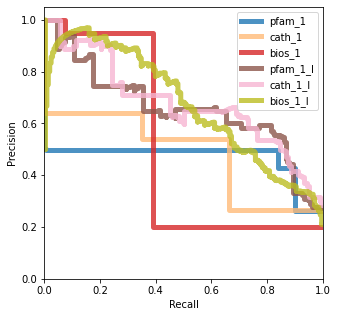

In [83]:
precisions = []
recalls = []
names = []

for r in results:
        names.append(r)
        precisions.append(results[r]['precisions'])
        recalls.append(results[r]['recalls'])
plot_pr_curves(precisions, recalls, names, "Siderophore")


# Plots of data

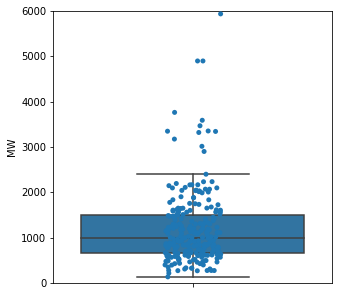

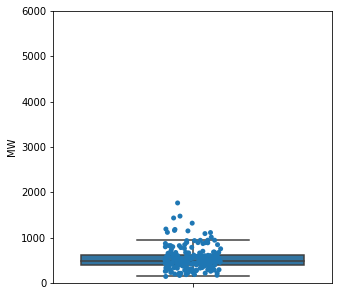

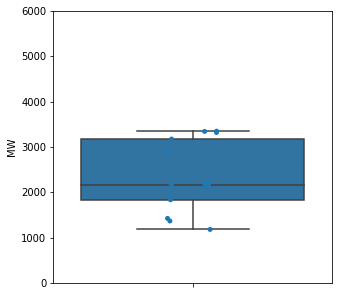

In [44]:
plt.rcParams["figure.figsize"] = (5,5)
sns.stripplot(merged_struct.query("ABC_tran > 0 & MFS_1 == 0 ")['MW'], orient='v')
sns.boxplot(merged_struct.query("ABC_tran > 0 & MFS_1 == 0 ")['MW'], fliersize=0, orient='v')
plt.ylim(0,6000)
plt.savefig('abc_tran_box.svg')
plt.show()

sns.stripplot(merged_struct.query("ABC_tran == 0 & MFS_1 > 0 ")['MW'], orient='v')
sns.boxplot(merged_struct.query("ABC_tran == 0 & MFS_1 > 0 ")['MW'], fliersize=0, orient='v')
plt.ylim(0,6000)
plt.savefig('mfs_box.svg')
plt.show()


sns.stripplot(merged_struct.query("ABC2_membrane_4 > 0")['MW'], orient='v')
sns.boxplot(merged_struct.query("ABC2_membrane_4 > 0 ")['MW'], fliersize=0, orient='v')
plt.ylim(0,6000)
plt.savefig('abc4_box.svg')
plt.show()

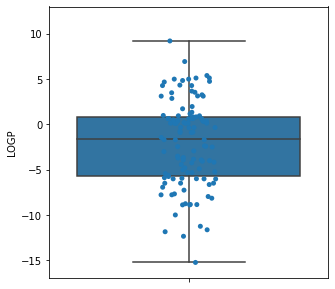

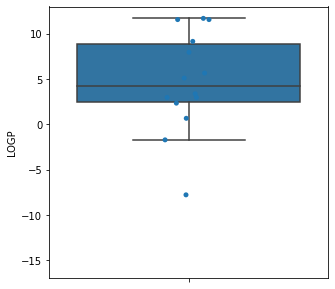

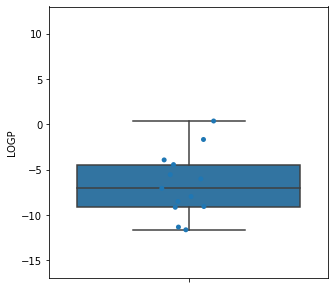

In [45]:
plt.rcParams["figure.figsize"] = (5,5)
sns.stripplot(merged_struct.query("ABC_membrane > 0")['LOGP'], orient='v')
sns.boxplot(merged_struct.query("ABC_membrane > 0")['LOGP'], fliersize=0, orient='v')
plt.ylim(-17,13)
plt.savefig("abc_mem_box.svg")
plt.show()

sns.stripplot(merged_struct.query("ABC2_membrane_3 > 0")['LOGP'], orient='v')
sns.boxplot(merged_struct.query("ABC2_membrane_3 > 0")['LOGP'], fliersize=0, orient='v')
plt.ylim(-17,13)
plt.savefig("abc2_box.svg")
plt.show()


sns.stripplot(merged_struct.query("ABC2_membrane_4 > 0")['LOGP'], orient='v')
sns.boxplot(merged_struct.query("ABC2_membrane_4 > 0 ")['LOGP'], fliersize=0, orient='v')
plt.ylim(-17,13)
plt.savefig("abc4_logp_box.svg")
plt.show()

(149, 45)
(421, 45)


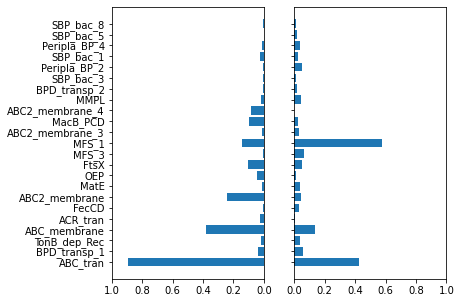

In [46]:
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams['svg.fonttype'] = 'none'


## Small vs large molecules
big = merged_struct[merged_struct.MW > 1000]
print(big.shape)

small = merged_struct[merged_struct.MW < 1000]
print(small.shape)

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(big[cols].sum().keys(), 
             big[cols].astype(bool).sum() / big[cols].shape[0], 
             align='center')

axes[1].barh(small[cols].sum().keys(), 
             small[cols].astype(bool).sum() / small[cols].shape[0], 
             align='center')

axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)

axes[0].invert_xaxis()
plt.savefig("Fig4a.svg")

plt.show()

# Stability analysis

In [47]:
def plot_features(dfs, name):
    plt.figure(figsize=(10,6))
    
    sns.swarmplot(x='vals', y='feature', data=dfs, size=5)
    sns.boxplot(x='vals', y='feature', data=dfs, color='white')

    plt.ylabel('Protein Families')
    plt.xlabel('Effect Size')
    plt.title(name)
    plt.savefig(name + ".svg")
    plt.show()

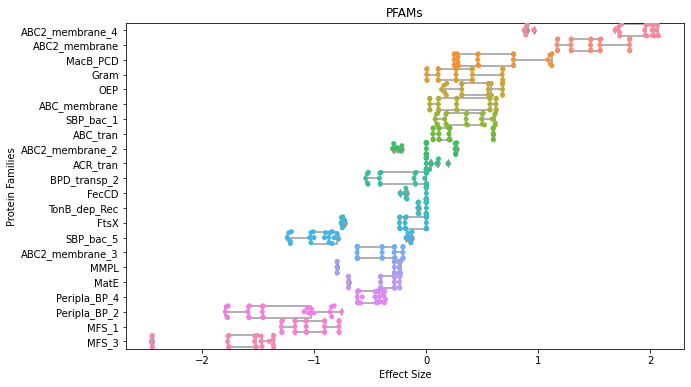

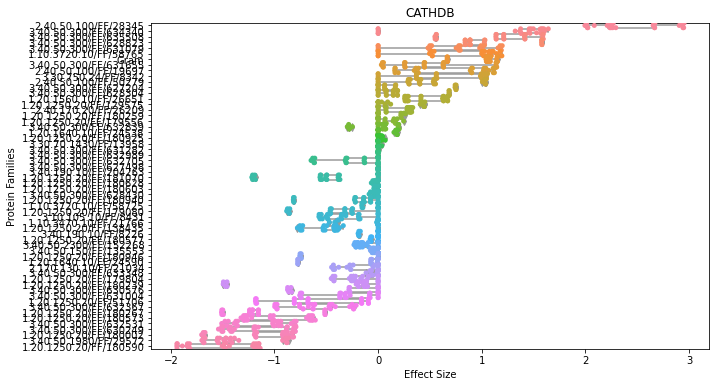

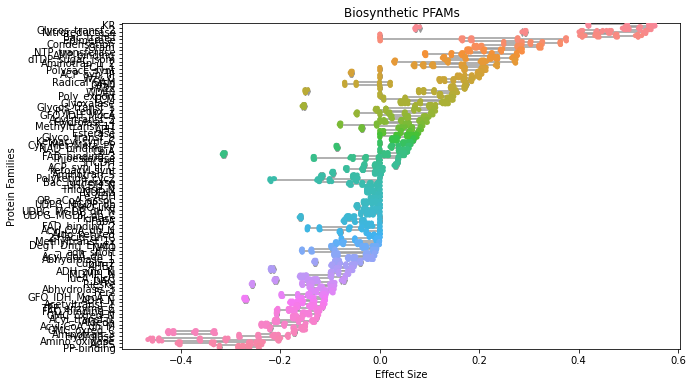

In [50]:
plot_features(results['pfam_1_l']['features'], 'PFAMs')
plot_features(results['cath_1_l']['features'], 'CATHDB')
plot_features(results['bios_1_l']['features'], 'Biosynthetic PFAMs')